# A comparison of cognitive and organizational classification of publications in the Social Sciences and Humanities:<br>additional material

This notebook is an accompaniment to the paper 'A comparison of cognitive and organizational classification of publications in the Social Sciences and Humanities', to be published in *Scientometrics*. It shows how the data were analyzed and the results were obtained.

## Loading data

First, we import the necessary modules. Next, load the data.

In [1]:
import csv
from collections import OrderedDict
from operator import itemgetter

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

from disciplines import *

%matplotlib inline
sns.set_style('ticks')

In [2]:
df = pd.read_csv('data/data.csv')

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Number of publications
len(df)

76076

Table 1:

In [4]:
df.groupby(['VABB-publicatietype', 'infogpstd']).size()

VABB-publicatietype  infogpstd
VABB-1               gp           27749
                     wos          30569
VABB-2               gp            1199
VABB-3               gp            2057
VABB-4               gp           11799
VABB-5               gp            1380
                     wos           1323
dtype: int64

Now we create three tables:
1. `fosdf`: FOS fields per publication
2. `vabbdf`: VABB disciplines per publication
3. `vabbdf_specific`: VABB disciplines per publication, excluding *Social sciences general* and *Humanities general*

In [5]:
fosdf = pivot_discipline_cols(df, [col for col in df.columns if col.startswith('FOS')])

In [6]:
vabbdf = df[vabb_discipline_names]
vabbdf_specific = df[vabb_discipline_names_specific]

Table 3:

In [7]:
fos_count = fosdf.sum(axis=1).astype(int)
vabb_count = vabbdf.sum(axis=1).astype(int)

counts = pd.DataFrame({
    'fos': fos_count,
    'vabb': vabb_count,
})

counts.groupby(['fos', 'vabb']).size().unstack().fillna(0).astype(int)

vabb,1,2,3,4,5,6,7,8
fos,,,,,,,,
1,53568,12809,2887,717,120,19,5,0
2,3804,1035,240,120,8,0,0,1
3,425,125,23,3,1,0,0,0
4,109,37,8,2,1,0,0,0
5,7,1,1,0,0,0,0,0


Use labels instead of numbers for FOS disciplines:

In [8]:
col_renamer = {num: name for num, name, _ in fos_disciplines}
fosdf = (fosdf.reindex(columns=[num for num, _, level in fos_disciplines if level != 1])
              .rename(columns=col_renamer))

## Networks

These networks show co-occurrences between VABB disciplines and between FOS fields. They can be visualized in [VOSviewer](http://www.vosviewer.com). In VOSviewer, choose `Create... > Create a map based on network data`, and fill in the locations of the map file and network file.

First, we have two functions that are used to write a map file and network file.

In [9]:
def write_map(G, fname, attrs):
    with open(fname, 'w', newline='') as fh:
        writer = csv.writer(fh, delimiter='\t')
        writer.writerow(['id', 'label'] + attrs)
        for i, n in enumerate(G.nodes(), start=1):
            writer.writerow([i, n] + [G.node[n][attr] for attr in attrs])
            

def write_network(G, fname):
    nodes = dict(zip(G.nodes(), range(1, len(G) + 1)))
    with open(fname, 'w', newline='') as fh:
        writer = csv.writer(fh, delimiter='\t')
        for u, v, d in G.edges(data=True):
            writer.writerow([nodes[u], nodes[v], d['weight']])

In [10]:
vabbdf = vabbdf.fillna(0)
c = vabbdf.T.dot(vabbdf)
G = nx.from_pandas_adjacency(c)

cluster_numbers = dict.fromkeys(vabb_discipline_names_socsci, 1)
cluster_numbers.update(dict.fromkeys(vabb_discipline_names_hum, 2))

weights = vabbdf.sum().to_dict()

for n in G:
    G.node[n]['cluster'] = cluster_numbers[n]
    G.node[n]['weight'] = weights[n]

write_map(G, 'maps/vabbmap.txt', ['cluster', 'weight'])
write_network(G, 'maps/vabbnet.txt')

In [11]:
fosdf = fosdf.fillna(0)
c = fosdf.T.dot(fosdf)
G = nx.from_pandas_adjacency(c)

cluster_numbers = {}
for num, name, level in fos_disciplines:
    if level == 1:
        current_top_level = int(num)
    else:
        cluster_numbers[name] = current_top_level
weights = fosdf.sum().to_dict()

for n in G:
    G.node[n]['cluster'] = cluster_numbers[n]
    G.node[n]['weight'] = weights[n]

write_map(G, 'maps/fosmap.txt', ['cluster', 'weight'])
write_network(G, 'maps/fosnet.txt')

## Cooccurrences between cognitive and organizational classification

### At aggregated level

Build a DataFrame `top_fosdf` of top-level FOS field(s) per publication

In [12]:
agg_fos = OrderedDict()
for num, name, level in fos_disciplines:
    if level == 1:
        current_list = []
        agg_fos[name] = current_list
    else:
        current_list.append(name)

top_fosdf = pd.DataFrame()
for k, v in agg_fos.items():
    top_fosdf[k] = (fosdf[v] == 1).any(axis=1).astype(int)

Build a DataFrame `top_vabbdf` of publications to top-level VABB disicplines (i.e., *Social sciences* and *Humanities*):

In [13]:
agg_vabb = OrderedDict()
agg_vabb['Social sciences'] = vabb_discipline_names_socsci
agg_vabb['Humanities'] = vabb_discipline_names_hum

top_vabbdf = pd.DataFrame()
for k, v in agg_vabb.items():
    top_vabbdf[k] = (vabbdf[v] == 1).any(axis=1).astype(int)

Figure 3:

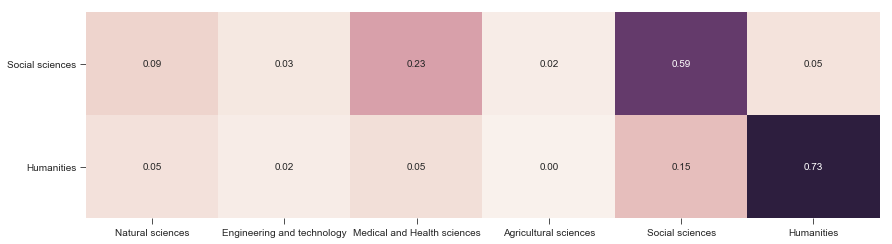

In [14]:
coocc_agg = make_coocc_table(top_vabbdf, top_fosdf)
coocc_agg = normalize_coocc_table(coocc_agg)
fig, ax = plot_heatmap(coocc_agg, annot=True, figsize=(12.5, 3.5), fmt='.2f', cbar=False)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tight_layout()

### At second level of fields

We start from the table without *Social sciences general* and *Humanities general*. Number of publications underlying this figure:

In [15]:
len(vabbdf_specific[vabbdf_specific.sum(axis=1) > 0])

71640

In [16]:
coocc = make_coocc_table(vabbdf_specific, fosdf)
coocc_norm = normalize_coocc_table(coocc)

Figure 4:

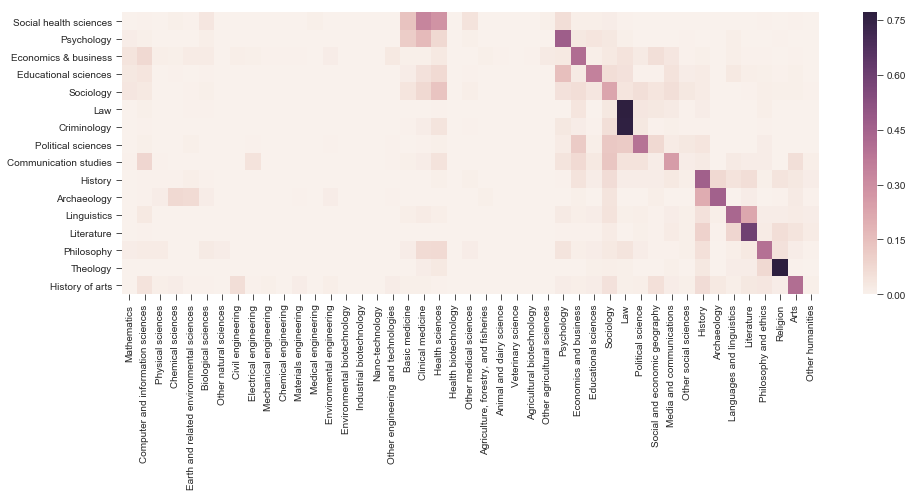

In [17]:
fig, ax = plot_heatmap(coocc_norm, figsize=(14, 7),
                       cmap=sns.cubehelix_palette(light=.95, as_cmap=True))

Let's see how strong the correspondence is between each VABB discipline and closest corresponding FOS field.

In [18]:
mapping = {
    # VABB: FOS
    'Social health sciences': 'Health sciences',
    'Psychology': 'Psychology',
    'Economics & business': 'Economics and business',
    'Educational sciences': 'Educational sciences',
    'Sociology': 'Sociology',
    'Law': 'Law',
    'Criminology': 'Law',
    'Political sciences': 'Political science',
    'Communication studies': 'Media and communications',
    'History': 'History',
    'Archaeology': 'Archaeology',
    'Linguistics': 'Languages and linguistics',
    'Literature': 'Literature',
    'Philosophy': 'Philosophy and ethics',
    'Theology': 'Religion',
    'History of arts': 'Arts',
}

In [19]:
correspondence = {k: coocc_norm.loc[k, v] for k, v in mapping.items()}
for k, v in sorted(correspondence.items(), key=itemgetter(1), reverse=True):
    print('{}: {:.1f}%'.format(k, v * 100))

Theology: 77.1%
Law: 76.5%
Criminology: 76.4%
Literature: 59.9%
Psychology: 46.7%
History: 46.1%
Archaeology: 45.6%
Linguistics: 43.5%
Economics & business: 41.0%
History of arts: 40.7%
Philosophy: 40.0%
Political sciences: 38.9%
Educational sciences: 34.2%
Social health sciences: 28.5%
Communication studies: 25.4%
Sociology: 23.1%


## Influence of collaboration and FOS multi-assignment

Visualize the difference to the original table: increases are in red and decreases in blue. The intensity of the color indicates the strength of increase or decrease.

Figure 5:

Text(0.5,-135.5,'')

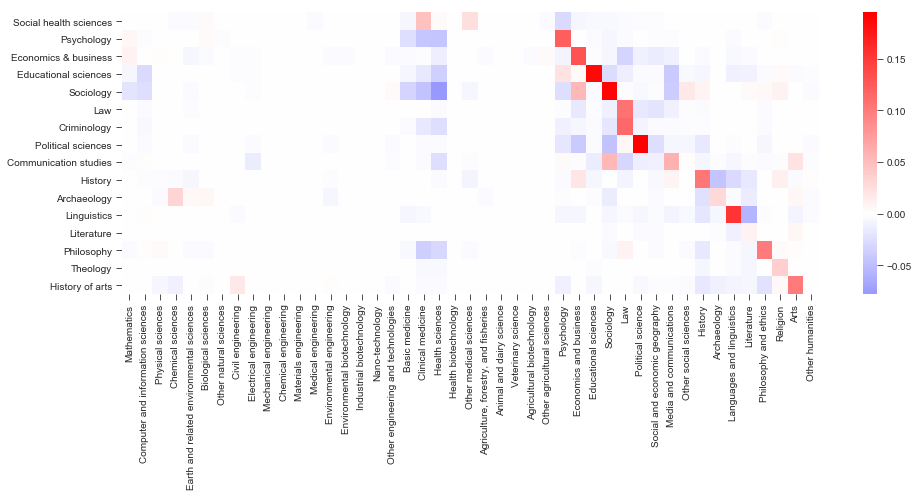

In [20]:
# Index of single-assignment publications
idx = df[(vabbdf.sum(axis=1) == 1) & (fosdf.sum(axis=1) == 1)].index

coocc_single_assignment = make_coocc_table(vabbdf_specific.loc[idx], fosdf.loc[idx])
coocc_single_assignment_norm = normalize_coocc_table(coocc_single_assignment)
single_assignment_diff = coocc_single_assignment_norm - coocc_norm

fig, ax = plot_heatmap(single_assignment_diff, center=0, cmap='bwr')
ax.set_xlabel('')

Single assignment at aggregate level:

In [21]:
coocc_single_assignment_agg = make_coocc_table(top_vabbdf.loc[idx], top_fosdf.loc[idx])
normalize_coocc_table(coocc_single_assignment_agg)

,Natural sciences,Engineering and technology,Medical and Health sciences,Agricultural sciences,Social sciences,Humanities
Social sciences,0.086692,0.019840,0.216184,0.014969,0.633418,0.028897
Humanities,0.043026,0.016135,0.031851,0.001195,0.120473,0.787319


Strongest increase:

In [22]:
single_assignment_diff.max(axis=1).sort_values()[-1:]

Political sciences    0.195012
dtype: float64

## Gini inequality index

In [23]:
def gini(x):
    # Source: https://stackoverflow.com/questions/39512260#39513799
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)
    mad = np.abs(np.subtract.outer(x, x)).mean()
    rmad = mad / np.mean(x)
    
    return 0.5 * rmad

Table 4:

In [24]:
pd.DataFrame({
    'Gini (all pubs)': coocc_norm.apply(gini, axis=1),
    'Gini (single-assignment)': coocc_single_assignment_norm.apply(gini, axis=1),
}).sort_values(ascending=False, by='Gini (all pubs)')


,Gini (all pubs),Gini (single-assignment)
Theology,0.931695,0.942141
Criminology,0.929458,0.958175
Law,0.916900,0.944414
Literature,0.902369,0.907449
Psychology,0.878184,0.898810
Archaeology,0.869607,0.894160
Social health sciences,0.865391,0.897137
Political sciences,0.854478,0.914583
Linguistics,0.836678,0.889072
History,0.813112,0.863233


Gini index for aggregated VABB disciplines *Social sciences* and *Humanities*:

In [25]:
coocc_agg.apply(gini, axis=1)

Social sciences    0.586628
Humanities         0.674614
dtype: float64